In [1]:
import pandas as pd
import numpy as np

In [2]:
# Manual inspections of monojet_Zp2000.0_DM_50.0_chan3.csv indicates a row can have at max 65 columns.
# This means an event can contain an event in monojet_Zp2000.0_DM_50.0_chan3.csv can contain at max 10 objects.
# To accomodate for the additional ';' delimiter at the end of line, we consider an additional column.

max_columns = 65
column_names = ['event ID', 'process ID', 'event weight', 'MET', 'METphi']
n_obj = int((max_columns - 5) / 5) 
for i in range(1, n_obj + 1): #Subtracting 5 because first few columns are meta-data.
    column_names.extend([f'obj{i}', f'E{i}', f'pt{i}', f'eta{i}', f'phi{i}'])
    
column_names.append('sentinel')

In [3]:
df = pd.read_csv('monojet_Zp2000.0_DM_50.0_chan3.csv', header=None, sep=',|;', 
                 names=column_names, engine='python')

In [4]:
df.drop('sentinel', axis=1, inplace=True)
df.head()

,event ID,process ID,event weight,MET,METphi,obj1,E1,pt1,eta1,phi1,...,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12
0,354,monojet_Zp2000.0_DM_50.0,0.000024,832841.0,-1.22431,b,947383.0,824498.0,-0.523103,1.644210,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,354,monojet_Zp2000.0_DM_50.0,0.000024,732115.0,1.17245,j,1069460.0,751597.0,0.858186,-1.842170,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,354,monojet_Zp2000.0_DM_50.0,0.000024,1056280.0,-3.06744,j,676000.0,640429.0,0.330450,0.704554,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
3,354,monojet_Zp2000.0_DM_50.0,0.000024,631781.0,1.64181,j,936707.0,616229.0,0.973383,-1.565920,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
4,354,monojet_Zp2000.0_DM_50.0,0.000024,457316.0,-1.87536,j,640313.0,589524.0,0.390749,1.237340,...,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [5]:
# filter the dataframe to keep only jet particles and their values of E, pt, eta and phi
filtered_particles = list()

for _, row in df.iterrows():
    for i in range(1, n_obj + 1): #iterate over different objects in an event.
        if(row[f'obj{i}'] == 'j'):
            e = row[f'E{i}']
            pt = row[f'pt{i}']
            eta = row[f'eta{i}']
            phi = row[f'phi{i}']
            
            filtered_particles.append([e, pt, eta, phi])
            
data = pd.DataFrame(filtered_particles, columns=['E', 'pt', 'eta', 'phi'])
print(f'The number of entries in the training data: {len(data)}')
print(data.head())

The number of entries in the training data: 22661
          E        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938


In [6]:
#Splitting the data into train and test splits
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=1729)

print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print(f'The number of entries in the training data: {len(train)}')
print(f'The number of entries in the validation data: {len(test)}')

Training sample:
               E         pt       eta       phi
10013   976059.0    48162.9  3.701440 -2.045010
20458  1557960.0  1358810.0 -0.530304 -1.091960
10667   103278.0    96602.1 -0.352841  2.540710
12549    31522.0    25080.4 -0.702196  1.964800
627     958447.0   603416.0  1.036860  0.763274


Testing sample:
               E        pt      eta       phi
5045   1652970.0  815901.0  1.33087 -2.160300
16581   126804.0   38630.2  1.85703 -3.110990
14297   238445.0   43793.7 -2.37781 -3.020250
9458    987941.0  427600.0  1.47994 -0.563225
18347   965804.0   93393.3 -3.02680  0.235121


The number of entries in the training data: 15862
The number of entries in the validation data: 6799


In [7]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save = True # Option to save figure

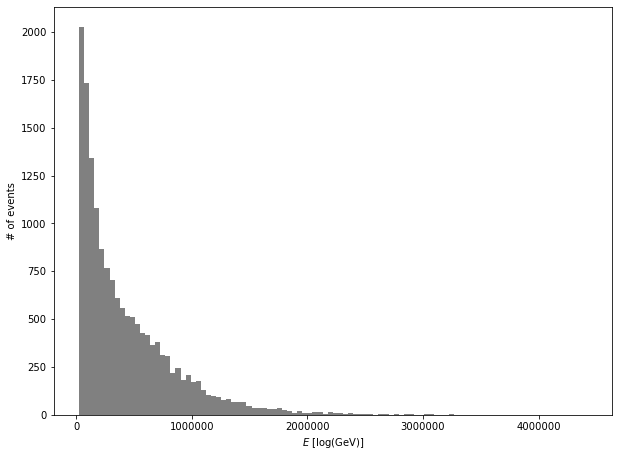

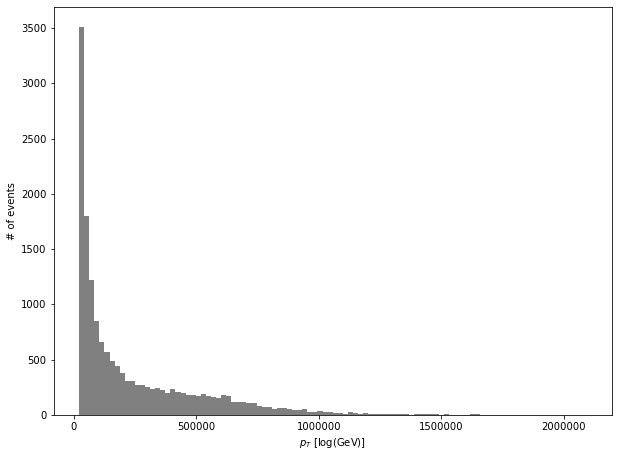

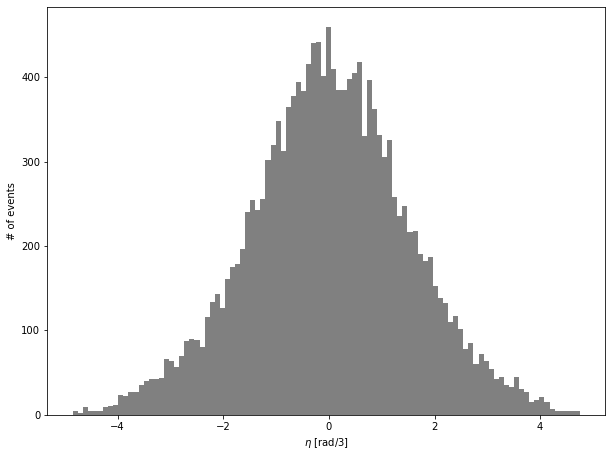

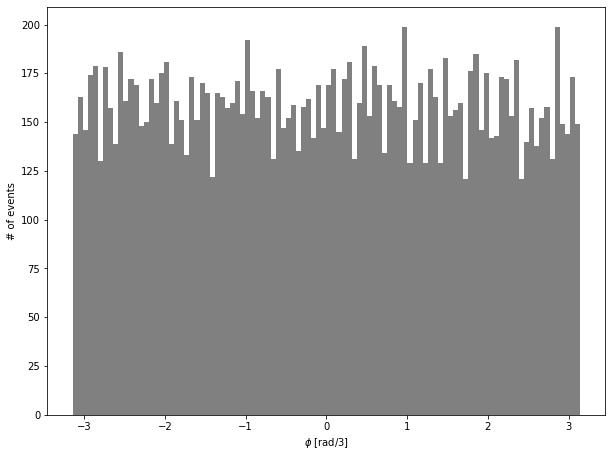

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

unit_list = ['[log(GeV)]', '[log(GeV)]', '[rad/3]', '[rad/3]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["E", "pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    plt.figure(figsize=(10,7.5))
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    if save:
        plt.savefig(os.path.join(save_dir,f'data_' + test.columns[kk] + '.png'))

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def apply_log(train_x, test_x, f_name):
    train_x[f_name] = train_x[f_name].apply(lambda x : np.log(1 + x))
    test_x[f_name] = test_x[f_name].apply(lambda x : np.log(1 + x))
    
    return train_x, test_x
    
def apply_scaler(train_x, test_x, f_name, scaler):
    scaler.fit(train_x[f_name].to_numpy().reshape(-1, 1))
    train_x[f_name] = scaler.transform(train_x[f_name].to_numpy().reshape(-1, 1))
    test_x[f_name] = scaler.transform(test_x[f_name].to_numpy().reshape(-1, 1))
    
    return train_x, test_x, scaler
    
def custom_scaler(train, test):
    #Since \eta follows a normal distribution, we can use standardScaler to scale it.
    #For E and pt we can use log(1 + x)
    # for \phi, we can use MinMaxScaling
    
    train_x = train.copy(deep=True)
    test_x = test.copy(deep=True)
    
    standard_scaler_eta = StandardScaler()
    min_max_scaler_e = MinMaxScaler()
    min_max_scaler_pt = MinMaxScaler()
    min_max_scaler_phi = MinMaxScaler()
    
    
    train_x, test_x = apply_log(train_x, test_x, 'E')
    train_x, test_x, min_max_scaler_e = apply_scaler(train_x, test_x, 'E', min_max_scaler_e)
    
    train_x, test_x = apply_log(train_x, test_x, 'pt')
    train_x, test_x, min_max_scaler_pt = apply_scaler(train_x, test_x, 'pt', min_max_scaler_pt)
    
    train_x, test_x, standard_scaler_eta = apply_scaler(train_x, test_x, 'eta', standard_scaler_eta)
    
    train_x, test_x, min_max_scaler_phi = apply_scaler(train_x, test_x, 'phi', min_max_scaler_phi)
    
    return train_x, test_x, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi

In [10]:
def apply_inverse_scaler(data_x, f_name, scaler):
    data_x[f_name] = scaler.inverse_transform(data_x[f_name].to_numpy().reshape(-1, 1))
    
    return data_x 

def apply_exp(data_x, f_name):
    data_x[f_name] = data_x[f_name].apply(lambda x : np.exp(1 + x))
    
    return data_x

def denormalise_data(data, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi):
    
    data_x = data.copy(deep=True)
    data_x = apply_inverse_scaler(data_x, 'E', min_max_scaler_e)
    data_x = apply_exp(data_x, 'E')
    
    data_x = apply_inverse_scaler(data_x, 'pt', min_max_scaler_pt)
    data_x = apply_exp(data_x, 'pt')
    
    data_x = apply_inverse_scaler(data_x, 'eta', standard_scaler_eta)
    
    data_x = apply_inverse_scaler(data_x, 'phi', min_max_scaler_phi)
    
    return data_x

In [11]:
# 1 for custom scaling, 2 for StandardScaler, 3 for MinMaxScaler
scaling_method = 1

if (scaling_method == 1):
    train_x, test_x, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi \
        = custom_scaler(train, test)

else:
    if (scaling_method == 2):
        scaler = StandardScaler()
    elif(scaling_method == 3):
        scaler = MinMaxScaler()
    
    scaler.fit(train)

    train_x = pd.DataFrame(scaler.transform(train.to_numpy()), columns=train.columns)
    test_x = pd.DataFrame(scaler.transform(test.to_numpy()), columns=test.columns)

print('Normalised Training sample:')
print(train_x.head())

print('\n')

print('Normalised Testing sample:')
print(test_x.head())

print('\n')

Normalised Training sample:
              E        pt       eta       phi
10013  0.709275  0.171328  2.448788  0.174370
20458  0.799368  0.905289 -0.356843  0.326093
10667  0.276523  0.324285 -0.239186  0.904402
12549  0.047880  0.027935 -0.470807  0.812719
627    0.705766  0.726893  0.682181  0.621440


Normalised Testing sample:
              E        pt       eta       phi
5045   0.810773  0.793193  0.877109  0.156016
16581  0.316062  0.122859  1.225951  0.004669
14297  0.437731  0.150429 -1.581733  0.019115
9458   0.711606  0.651202  0.975942  0.410265
18347  0.707240  0.316861 -2.012011  0.537360




In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

from fastai import learner
from fastai.data import core

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [13]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [14]:
  class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [15]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.002290867641568184
Learning rate with the steepest gradient: 0.0008317637839354575


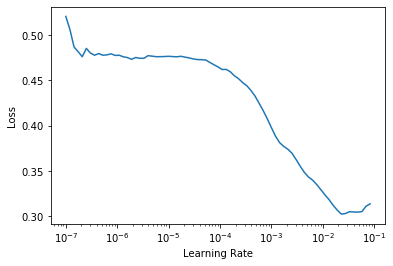

In [16]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [17]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.19005268812179565, 0.07424296438694, '00:00']
[0, 0.19005268812179565, 0.07424296438694, '00:00']
[1, 0.09502657502889633, 0.05848870426416397, '00:00']
[1, 0.09502657502889633, 0.05848870426416397, '00:00']
[2, 0.05768696218729019, 0.0332881435751915, '00:00']
[2, 0.05768696218729019, 0.0332881435751915, '00:00']
[3, 0.034723132848739624, 0.022866863757371902, '00:00']
[3, 0.034723132848739624, 0.022866863757371902, '00:00']
[4, 0.021404236555099487, 0.00762699730694294, '00:00']
[4, 0.021404236555099487, 0.00762699730694294, '00:00']
[5, 0.008893500082194805, 0.00293837976641953, '00:00']
[5, 0.008893500082194805, 0.00293837976641953, '00:00']
[6, 0.004195244982838631, 0.0017682495526969433, '00:00']
[6, 0.004195244982838631, 0.0017682495526969433, '00:00']
[7, 0.0019825573544949293, 0.0007324891048483551, '00:00']
[7, 0.0019825573544949293, 0.0007324891048483551, '00:00']
[8, 0.0009906446794047952, 0.00044189192703925073, '00:00']
[8, 0.0009906446794047952, 0.00044189192703925

[69, 1.965788032975979e-05, 8.554645319236442e-06, '00:00']
[69, 1.965788032975979e-05, 8.554645319236442e-06, '00:00']
[70, 1.2350111319392454e-05, 8.230128514696844e-06, '00:00']
[70, 1.2350111319392454e-05, 8.230128514696844e-06, '00:00']
[71, 1.0983449101331644e-05, 6.644386303378269e-06, '00:00']
[71, 1.0983449101331644e-05, 6.644386303378269e-06, '00:00']
[72, 1.3056582247372717e-05, 2.1793875930598006e-05, '00:00']
[72, 1.3056582247372717e-05, 2.1793875930598006e-05, '00:00']
[73, 9.538065569358878e-06, 8.779697054706048e-06, '00:00']
[73, 9.538065569358878e-06, 8.779697054706048e-06, '00:00']
[74, 7.889418156992178e-06, 4.734970389108639e-06, '00:00']
[74, 7.889418156992178e-06, 4.734970389108639e-06, '00:00']
[75, 7.518821348639904e-06, 7.295807790796971e-06, '00:00']
[75, 7.518821348639904e-06, 7.295807790796971e-06, '00:00']
[76, 6.232051418919582e-06, 5.945578777755145e-06, '00:00']
[76, 6.232051418919582e-06, 5.945578777755145e-06, '00:00']
[77, 6.127095275587635e-06, 8.58

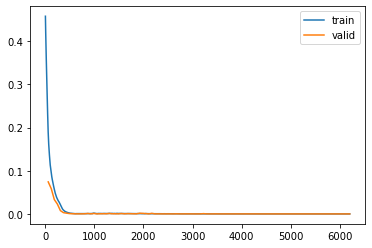

In [18]:
recorder.plot_loss()

In [19]:
learn.validate()

(#1) [1.7246748029720038e-06]

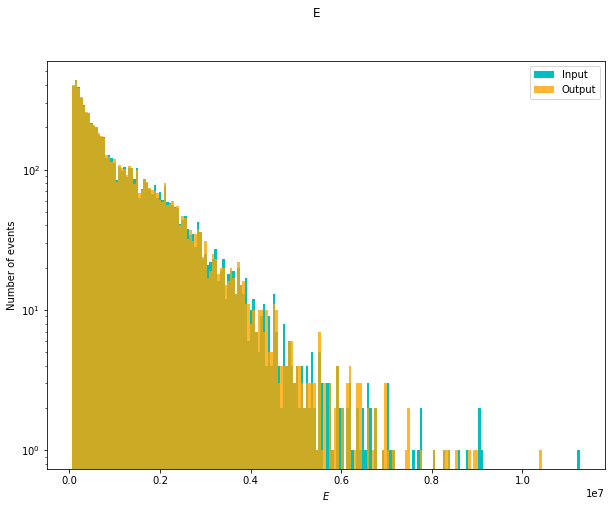

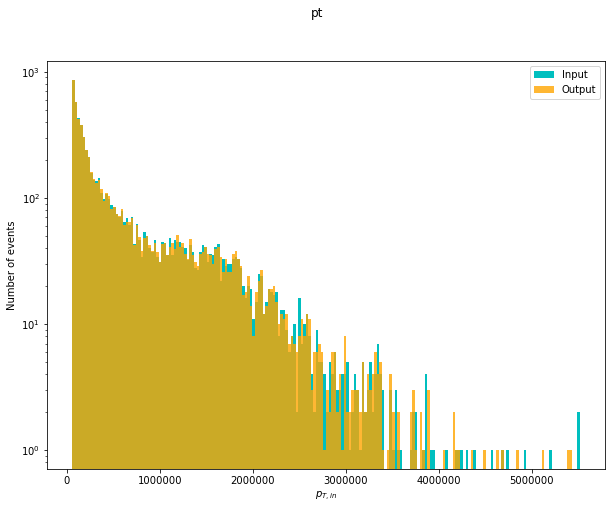

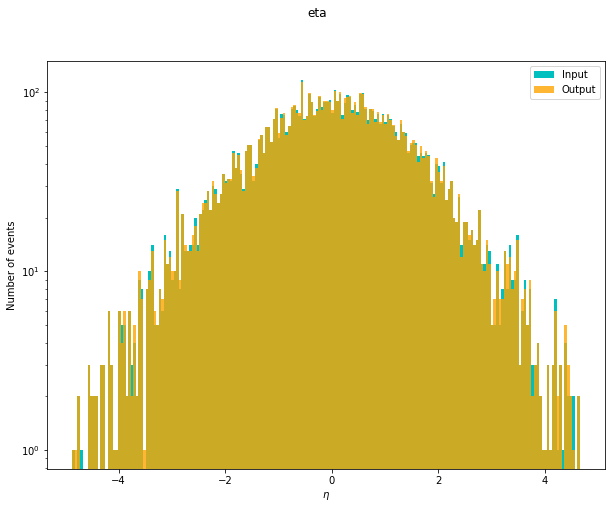

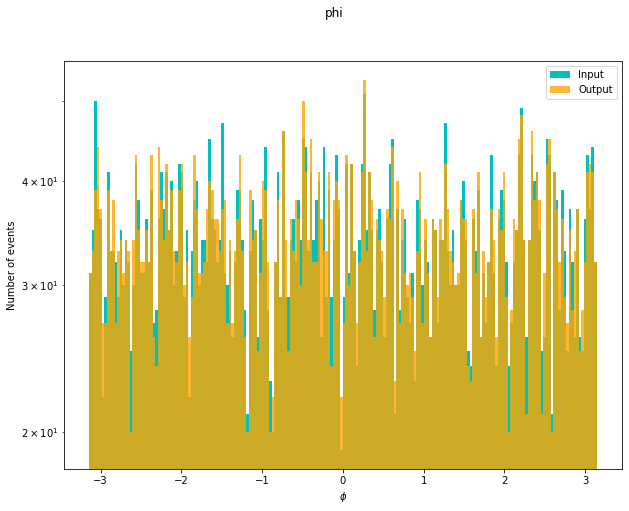

In [20]:
import numpy as np

plt.close('all')
variable_list = [r'$E$', r'$p_{T,in}$', r'$\eta$', r'$\phi$']

line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

if (scaling_method == 1):
    unnormalized_data_df = denormalise_data(data_df, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi)
    unnormalized_pred_df = denormalise_data(pred_df, min_max_scaler_e, min_max_scaler_pt, standard_scaler_eta, min_max_scaler_phi)
else:
    unnormalized_data_df = pd.DataFrame(scaler.inverse_transform(data), columns=data_df.columns)
    unnormalized_pred_df = pd.DataFrame(scaler.inverse_transform(pred), columns=pred_df.columns)
    
unnormalized_data = unnormalized_data_df.to_numpy()
unnormalized_pred = unnormalized_pred_df.to_numpy()
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure(figsize=(10,7.5))
    plt.ticklabel_format(axis="both", style="sci")
    n_hist_data, bin_edges, _ = plt.hist(unnormalized_data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(unnormalized_pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    plt.legend()
    if save:
        plt.savefig(os.path.join(save_dir,'compression_' + test.columns[kk] + '_' + str(scaling_method) +'.png'))

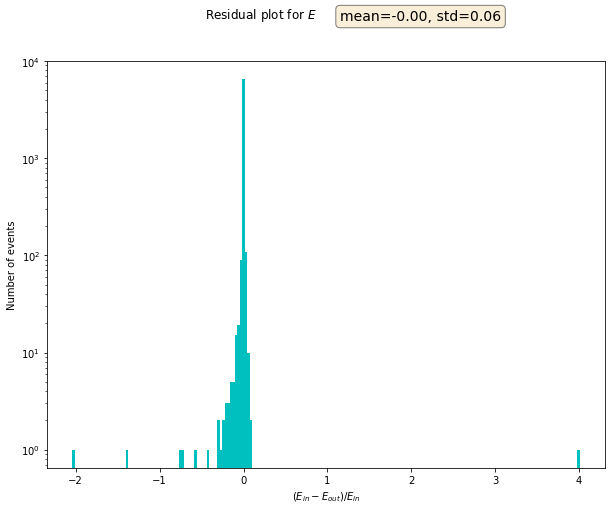

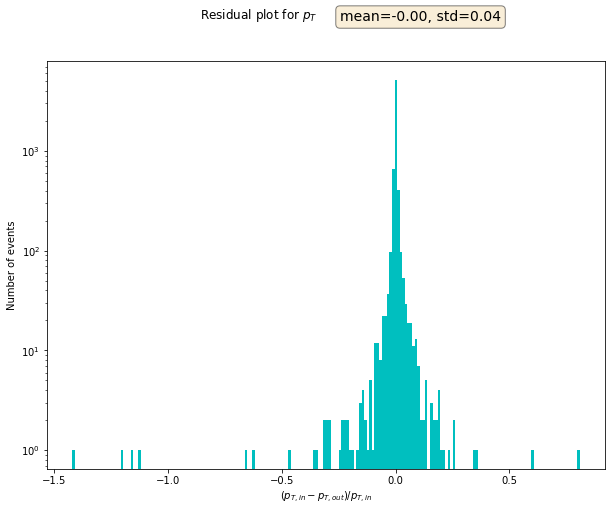

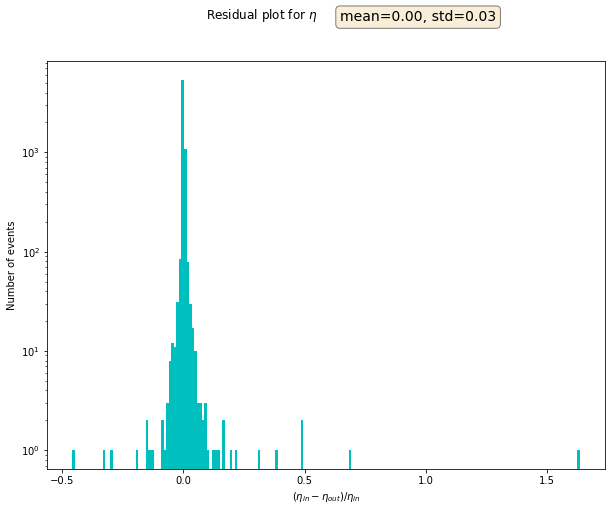

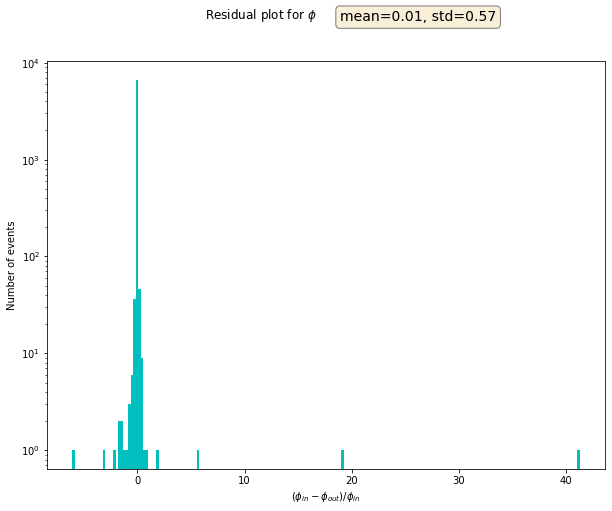

In [21]:
residual_df = (data_df - pred_df) / data_df
residual_data = residual_df.to_numpy()

variable_list = [r'$(E_{in} - E_{out})/E_{in}$', r'$(p_{T, in} - p_{T, out})/p_{T, in}$', 
                 r'$(\eta_{in} - \eta_{out})/\eta_{in}$', r'$(\phi_{in} - \phi_{out})/\phi_{in}$']
title_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

n_bins = 200
for kk in np.arange(4):
    inset_text_str = ', '.join((
        'mean=%.2f' % (np.mean(residual_data[:, kk]), ),
        'std=%.2f' % (np.std(residual_data[:, kk]), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    
    fig, ax = plt.subplots(figsize=(10, 7.5))
    plt.text(0.525, 1.125, inset_text_str, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    n_hist_data, bin_edges, _ = plt.hist(residual_data[:, kk], color=colors[1], bins=n_bins)
    plt.suptitle('Residual plot for ' + title_list[kk], horizontalalignment='right')
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('Number of events')
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,'residual_' + residual_df.columns[kk] + '_' + str(scaling_method) + '.png'))